In [174]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd.numpy.linalg import det
from autograd.numpy.linalg import trace
from autograd.numpy.linalg import inv
from autograd.scipy.stats import norm
from autograd.scipy.special import gamma as gammaFn

from autograd import grad

%matplotlib inline

Utility functions...

In [167]:
def besselFn_helper(x, v=5, M=10):
    s = 0.
    for m in xrange(M):
        s += (1./(gammaFn(m+1)*gammaFn(m+v+1))) * (x/2.)**(2*m+v)
    return s

def besselFn(v, x):
    return np.pi/2. * (besselFn_helper(x,-v) - besselFn_helper(x,v))/np.sin(np.pi*v)

# Stein Variational Gradient Descent
### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Liu and Wang propose a general purpose algorithm for Bayesian inference.

### Kernel Functions

In [168]:
# Radial Basis Function (Gaussian)
def rbf(x1, x2, params={'lengthScale': 1}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))

# Matern
def matern(x1, x2, params={'v': 1 ,'l': 6.}):
    temp = ((np.sqrt(2*params['v'])/params['l']) * np.sum(np.abs(x1-x2)))
    return (2**(1-params['v'])/gammaFn(params['v'])) * temp**params['v'] * besselFn(params['v'], temp) 

# RBF w/ von Neumann Boundary at 0
def reflect_rbf(x1, x2, params={'lengthScale': 1}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2)) + np.exp((-.5/params['lengthScale']) * np.sum((x1+x2)**2))

### Stein Operator

In [169]:
### perform stein var. grad. descent
def steinOp(x, idx, dLogModel, params, kernel, kernelParams=None):
    returnVal = 0.
    n = len(x)
    for sampleIdx in xrange(n):
        if sampleIdx == idx: continue
        returnVal += kernel['f'](x[sampleIdx], x[idx])*dLogModel(x[idx], params) + kernel['df'](x[sampleIdx], x[idx])
    return 1./(n-1) * returnVal

## Models

### Gaussian Mixture Model

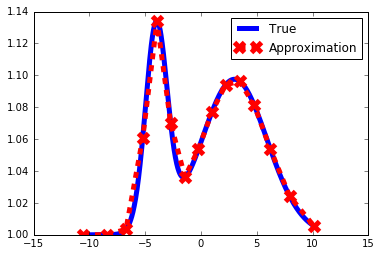

In [173]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})
                                         
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.normal

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0())
    
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.legend()

### Gamma Factor Analysis

In [178]:
# Model
def logPostFA(W, X, params):
    N = X.shape[0]
    D,K = W.shape
    Q = np.dot(W, W.T)
    log_prior = D*K*params['a']*np.log(params['b']) - D*K*np.log(gammaFn(params['a'])) + \
                    np.sum((params['a']-1)*np.log(W)) - np.sum(params['b']*W)
    return N/2. * np.log(det(Q)) - .5*trace(np.dot(np.dot(X.T,X), inv(Q))) + log_prior

K = 50
D = 100

logPost = logPostFA
dLogPost = grad(logPost)
params = {
    'a': 1.,
    'b': 1.
}

# kernel
kernel = {'f': reflect_rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.gamma

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0(shape=1, size=(D,K)))
    
"""
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.legend()
"""

'\nmaxEpochs = 100\nlr = 2.\nfor epochIdx in xrange(maxEpochs):\n    for idx in xrange(n):\n        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)\n\nx.sort()\nprobs = [np.exp(logModel(z, params)) for z in x]    \nx_true = np.linspace(-10, 10, 1000)\nprobs_true = [np.exp(logModel(z, params)) for z in x_true]\n\nplt.plot(x_true, probs_true, \'b-\', linewidth=5, label="True")\nplt.plot(x, probs, \'rx--\', markersize=10, mew=5, linewidth=5, label="Approximation")\nplt.legend()\n'